This file was predominantly created by prompting AI. 

In [244]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os 
import matplotlib.ticker as ticker
from main import evaluate
from opponent import make_opponent
from gymnasium import spaces
from TD3_agent import TD3_Agent
import hockey.hockey_env as hockey_env


In [245]:
# STYLE SETUP
plt.rcParams.update({
    'figure.facecolor':     'white',#'#fafafa',
    'axes.facecolor':       'white', #'#fafafa',
    'axes.edgecolor':       '#cccccc',
    'axes.grid':            True,
    'axes.spines.top':      False,
    'axes.spines.right':    False,
    'axes.xmargin':         0.01,
    'axes.ymargin':         0.0,   
    'grid.alpha':           0.3,
    'grid.color':           '#888888',
    'grid.linestyle':       '--',
    'font.family':          'sans-serif',
    'font.sans-serif':      ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size':            11,
    'axes.titlesize':       14,
    'axes.titleweight':     'bold',
    'axes.labelsize':       12,
    'legend.fontsize':      10,
    'legend.frameon':       False,
    #'legend.framealpha':    0.9,
    'legend.edgecolor':     '#cccccc',
    'figure.dpi':           130,
    'savefig.dpi':          200,
    'savefig.bbox':         'tight',
})

COLORS = ['#2176AE', # blue
          '#57A773', # green
          '#D4A843', # yellow
          '#E87EA1', # pink
          '#E05A3A', # orange
          '#8B5FBF', # purple
          '#27EEF5', # turquoise
          '#F52754', # red
          '#B2DE90', # light green
          ]

In [246]:
# Noise-type color mapping (inspired by colored noise spectrum)
NOISE_COLORS = {
    "P":  "#E87EA1",   # pink noise → pink
    "OU": "#C0392B",   # Ornstein-Uhlenbeck ≈ red/brown noise → red
    "G":  "#2B2B2B",   # Gaussian = white noise → dark charcoal
}

def get_noise_color(label: str) -> str:
    first_part = label.split(",")[0].split("\n")[0].strip()
    if first_part.startswith("OU"):
        return NOISE_COLORS["OU"]
    elif first_part.startswith("G"):
        return NOISE_COLORS["G"]
    elif first_part.startswith("P"):
        return NOISE_COLORS["P"]
    return "#333333"

In [247]:
def get_line_style(label: str) -> dict:
    has_per = "PER" in label
    return {
        "linestyle": "-" if has_per else "--",
        #"marker":    "o" if has_per else None,
        #"markevery":  max(1, 50 // 5),  
        #"markersize": 4,
    }

In [248]:
def sort_legend(handles, labels):
    LEGEND_ORDER = ["G", "G + PER", "OU", "OU + PER", "P", "P + PER"]
    order_map = {name: i for i, name in enumerate(LEGEND_ORDER)}
    paired = list(zip(handles, labels))
    paired.sort(key=lambda x: order_map.get(x[1], 999))
    return zip(*paired)

# Load the selected agents

In [249]:
def load_logs(map: dict) -> dict:
    runs = {}
    for label, path in map.items():
        if not os.path.exists(path):
            print(f"skipping {label}: {path} not found")
            continue
        df = pd.read_csv(path)
        df.columns = df.columns.str.strip()
        runs[label] = df
    return runs

In [250]:
# load the data 
TRAINING_wins_map = {"weak": {
    "G\n1991359": "/Users/Anne/RL/Hockey-TD3/1991359/logs/win_rate_log.csv", 
    "OU + PER\n1986413": "./1986413/logs/win_rate_log.csv",
    "OU\n1986415": "/Users/Anne/RL/Hockey-TD3/1986415/logs/win_rate_log.csv",
    "P\n1991360": "/Users/Anne/RL/Hockey-TD3/1991360/logs/win_rate_log.csv",
},
"strong": {
    "G + PER\n1986633": "./1986633/logs/win_rate_log.csv",
    "OU + PER\n1986620": "./1986620/logs/win_rate_log.csv",
    "P + PER\n1986341": "./1986341/logs/win_rate_log.csv",
}} 


In [251]:
def strip_job_ids(wins_map: dict) -> dict:
    """Strip job IDs from labels, keeping only noise + buffer config."""
    cleaned = {}
    for opponent, runs in wins_map.items():
        cleaned[opponent] = {}
        for label, path in runs.items():
            clean_label = label.split("\n")[0].strip()
            cleaned[opponent][clean_label] = path
    return cleaned

TRAINING_wins_map = strip_job_ids(TRAINING_wins_map)

In [252]:
weak_runs = load_logs(TRAINING_wins_map["weak"])
strong_runs = load_logs(TRAINING_wins_map["strong"])

In [253]:
# check
for label in TRAINING_wins_map["strong"]:
    print(f"{label!r} → {get_noise_color(label)}")

'G + PER' → #2B2B2B
'OU + PER' → #C0392B
'P + PER' → #E87EA1


# Win rate across training

In [254]:
EPISODE_MAX = 10_000

In [255]:
def plot_win_rate_comparison(panels: dict, figsize=(14, 5)):
    n_panels = len(panels)
    fig, axes = plt.subplots(1, n_panels, figsize=figsize, sharey=True)
    if n_panels == 1:
        axes = [axes]

    all_handles, all_labels = [], []

    for ax, (panel_title, runs) in zip(axes, panels.items()):
        for i, (label, df) in enumerate(runs.items()):
            c = get_noise_color(label)
            display_label = label.replace("\n", " — ")

            # PER runs get solid lines, non-PER get dashed
            #ls = "-" if "PER" in label else "--"
            line_style = get_line_style(label)

            ax.plot(df["episode"], df["win_rate"], color=c, linewidth=2,
                    label=display_label, **line_style)

        ax.set_title(f"{panel_title} BasicOpponent")
        ax.set_xlabel("Training episode")
        ax.set_xlim(0, EPISODE_MAX)
        ax.set_ylim(-0.05, 1.05)
        ax.axhline(0.55, color="#aaaaaa", linestyle="--", linewidth=1,
                   alpha=0.8)
        ax.axhline(0.55, color="#aaaaaa", linestyle="--", linewidth=1, alpha=0.8)
        ax.text(EPISODE_MAX * 0.97, 0.56, "55% threshold",
                ha="right", va="bottom", fontsize=8, color="#aaaaaa")
        
        import matplotlib.ticker as mticker
        ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

        # collect handles for global legend (avoid duplicates)
        h, l = ax.get_legend_handles_labels()
        for hi, li in zip(h, l):
            if li not in all_labels:
                all_handles.append(hi)
                all_labels.append(li)

        #ax.legend(loc="lower right", fontsize=9)

    axes[0].set_ylabel("Win rate")

    sorted_handles, sorted_labels = sort_legend(all_handles, all_labels)
    fig.legend(sorted_handles, sorted_labels,
               loc="center right",
               bbox_to_anchor=(1.15, 0.5))
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.18)  # make room for legend

    fig.tight_layout()
    return fig

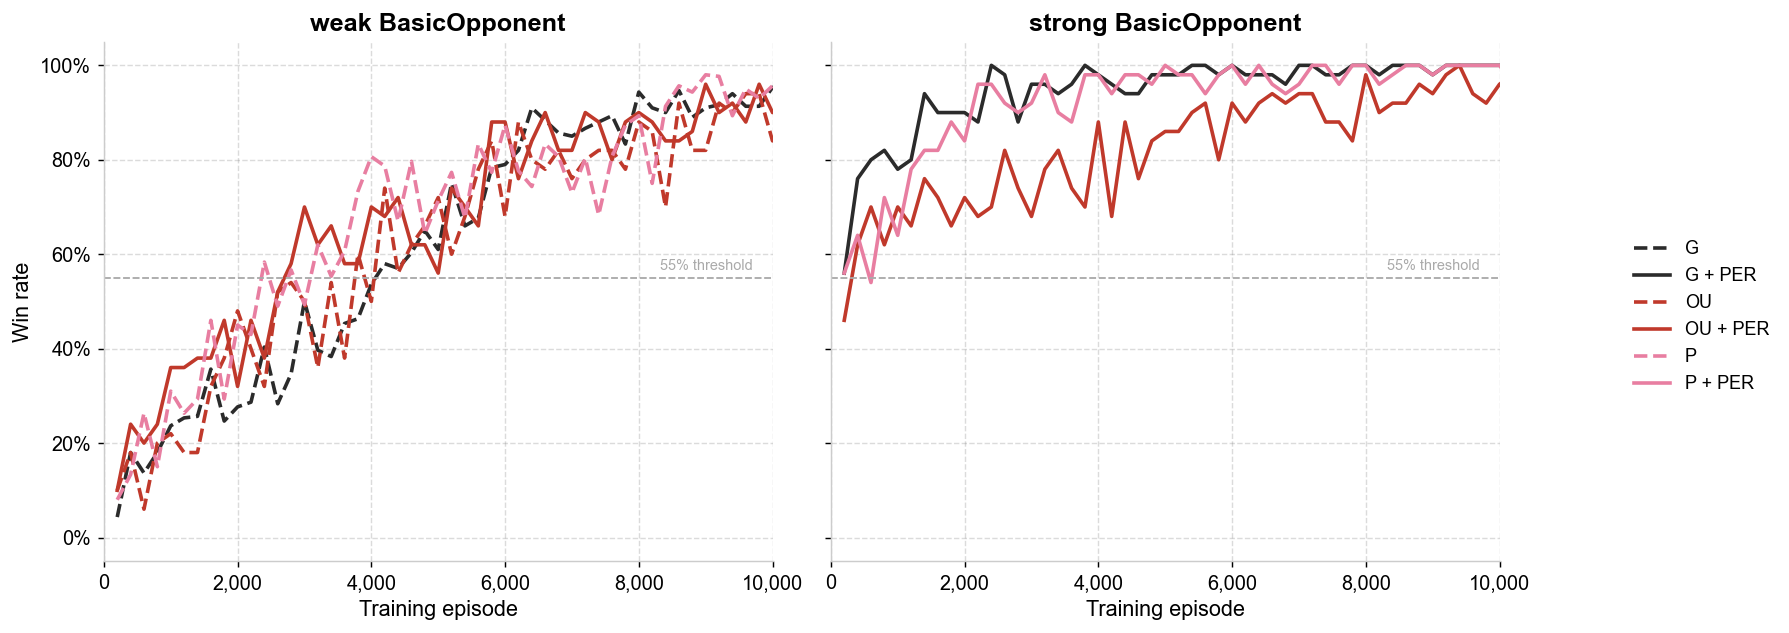

In [256]:
fig = plot_win_rate_comparison(
    {"weak": weak_runs, "strong": strong_runs},
    figsize=(12, 5),
)
# fig.savefig("win_rate_comparison.pdf")
plt.show()